In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal, custom_reward, one_hot
from rmab.plots import plot_line_plot_parameter, plot_tradeoff_curve, process_two_parameter_data, process_one_parameter_data, process_zero_parameter_data, aggregate_data, aggregate_normalize_data
import seaborn as sns
import itertools 
from scipy import stats
from rmab.fr_dynamics import get_all_transitions
from rmab.omniscient_policies import random_policy
from rmab.simulator import RMABSimulator, run_heterogenous_policy
import random 
import math
from copy import deepcopy

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [26]:
colors_by_method = {}
baseline_methods = ['random','whittle_activity','greedy','mcts','dqn_step','dqn']
whittle_methods = ['linear_whittle','shapley_whittle_custom']
iterative_methods = ['iterative_whittle','shapley_iterative_whittle']
mcts = ['mcts_linear','mcts_shapley']
non_baselines = whittle_methods + iterative_methods
time_policies = ["shapley_iterative_whittle_100","shapley_iterative_whittle_10","shapley_iterative_whittle_1"]

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(whittle_methods) + len(iterative_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(mcts)))
winter = plt.cm.spring(np.linspace(0, 1, len(time_policies)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(non_baselines):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(mcts):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(time_policies):
    colors_by_method[m] = winter[i] 
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

In [30]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(non_baselines+mcts+time_policies):
    shapes_by_method[m] = all_shapes[i]



## NeurIPS 2024 Plots

### Budget and Number of Arms

### Baselines

(2.391739582335734, 1.1765712253976444) (2.8380237714595826, 1.0742711809448178)
(2.391739582335734, 1.1765712253976444) (2.8380237714595826, 1.0742711809448178)
(2.391739582335734, 1.1765712253976444) (2.8380237714595826, 1.0742711809448178)
(2.391739582335734, 1.1765712253976444) (2.8380237714595826, 1.0742711809448178)
(2.391739582335734, 1.1765712253976444) (2.8380237714595826, 1.0742711809448178)


KeyError: 'mcts_reward'

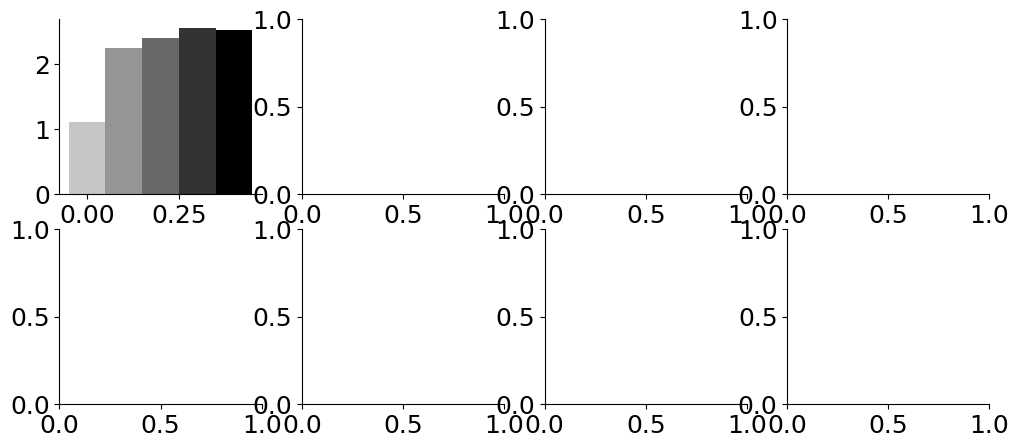

<Figure size 700x400 with 0 Axes>

In [59]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Linear MCTS","Linear Shapley","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 100}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1])
        
            if m == 'optimal' and n == 4:
                axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_xlabel(reward_names[j])

axs[0,0].set_ylabel("4 Arms")
axs[1,0].set_ylabel("10 Arms")

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=12)

fig.supylabel("Reward Rel. Random",fontsize=20,x=0.06)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


In [32]:
method_names = ['random','whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','optimal']
nice_names = ["Random","Vanilla Whittle","Greedy","MCTS","RL","RL Greedy","Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Optimal"]
width = 0.1
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform'}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

a = []
for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 
        score_by_n = []
        std_by_n = []

        dataset = "reward_variation/{}".format(datasets[j])

        temp_params = deepcopy(baseline_params)
        for p in params[j]:
            temp_params[p] = params[j][p]
                    
        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        
        for m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']:
            a.append(results['whittle_activity_reward'][0]/results['{}_reward'.format(m)][0])
np.mean(a)

0.8475102378885415

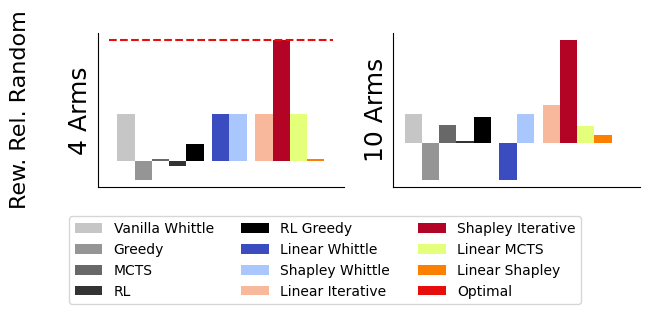

In [56]:
fig, axs = plt.subplots(1,2, figsize=(7, 2))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","RL","RL Greedy","Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Linear MCTS","Linear Shapley","Optimal"]
width = 0.1
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform'}
datasets = ['max_reward']
reward_names = [""]
params = [{'reward_type': 'max', 'prob_distro': 'one_time'}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    j = 0
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/all"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
            dataset = "reward_variation/{}".format(datasets[j])

        temp_params = deepcopy(baseline_params)
        for p in params[j]:
            temp_params[p] = params[j][p]
                    
        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_normalize_data(results,baseline="random")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    
        if m == 'optimal' and n == 4:
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(reward_names[j])

axs[0].set_ylabel("4 Arms")
axs[1].set_ylabel("10 Arms")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.45,0),fontsize=10)

fig.supylabel("Rew. Rel. Random",fontsize=16,x=0)
fig.savefig("../../results/figures/all_rewards_2.pdf",dpi=300, bbox_inches='tight')


### Impact of Linearity

{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'arm_set_low': 1, 'arm_set_high': 3, 'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'arm_set_low': 2, 'arm_set_high': 3, 'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'arm_set_low': 1, 'arm_set_high': 4, 'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'arm_set_low': 2, 'arm_set_high': 4, 'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'arm_set_low': 3, 'arm_set_high': 4, 'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
{'vol

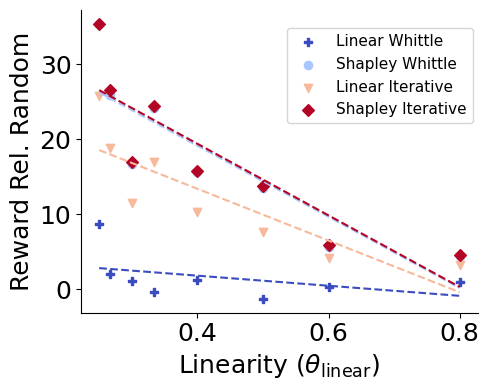

In [34]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']#,'mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]#,"MCTS Shapley"]

arm_low_high = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

plt.figure(figsize=(5,4))

x_axis = []
plots_by_method = {} 
std_by_method = {}
for i in method_names:
    plots_by_method[i] = []

for arm_high,arm_low in arm_low_high:
    params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5,'n_arms': 10, 'arm_set_low': arm_low,'arm_set_high': arm_high,'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
    dataset = "reward_variation/subset_reward"
    results = get_results_matching_parameters(dataset,"",params)
    print(params)
    x_axis.append(results[0]['ratio'])

    results = aggregate_normalize_data(results,baseline="random")
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])

for i,m in enumerate(method_names):
    # plt.fill_between(x_axis, np.array(plots_by_method[m]) - np.array(std_by_method[m]), np.array(plots_by_method[m]) + np.array(std_by_method[m]), alpha=0.2,  color=color_palette[i])
    zipped_values = zip(x_axis,plots_by_method[m])
    zipped_values = [i for i in zipped_values if i[0] < 1.0]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    # plt.plot(x,y,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    plt.plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])


# plt.xlim([0.74,1.0])
plt.xlabel("Linearity ($\\theta_{\\mathrm{linear}}$)")
plt.ylabel("Reward Rel. Random")
plt.legend(fontsize=11,bbox_to_anchor=(0.5,0.6))
plt.tight_layout()
plt.savefig("../../results/figures/linearity.pdf",dpi=300, bbox_inches='tight')

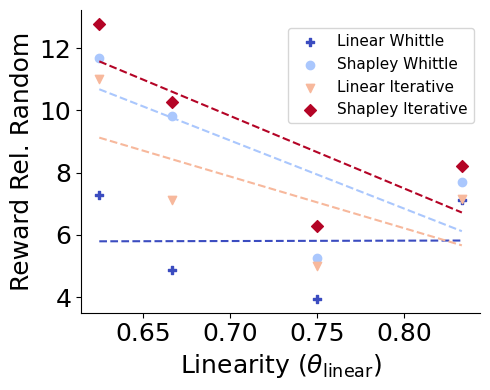

In [35]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']#,'mcts_shapley']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]#,"MCTS Shapley"]

arm_low_high = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

plt.figure(figsize=(5,4))

x_axis = []
plots_by_method = {} 
std_by_method = {}
for i in method_names:
    plots_by_method[i] = []

for arm_high,arm_low in arm_low_high:
    params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2,'n_arms': 4, 'arm_set_low': arm_low,'arm_set_high': arm_high,'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover'}
    dataset = "reward_variation/subset_reward"
    results = get_results_matching_parameters(dataset,"",params)
    x_axis.append(results[0]['ratio'])

    results = aggregate_normalize_data(results,baseline="random")
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])

for i,m in enumerate(method_names):
    # plt.fill_between(x_axis, np.array(plots_by_method[m]) - np.array(std_by_method[m]), np.array(plots_by_method[m]) + np.array(std_by_method[m]), alpha=0.2,  color=color_palette[i])
    zipped_values = zip(x_axis,plots_by_method[m])
    zipped_values = [i for i in zipped_values if i[0] < 1.0]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    # plt.plot(x,y,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    plt.plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])


# plt.xlim([0.74,1.0])
plt.xlabel("Linearity ($\\theta_{\\mathrm{linear}}$)")
plt.ylabel("Reward Rel. Random")
plt.legend(fontsize=11,bbox_to_anchor=(0.5,0.6))
plt.tight_layout()
plt.savefig("../../results/figures/linearity_2.pdf",dpi=300, bbox_inches='tight')

### Time Taken

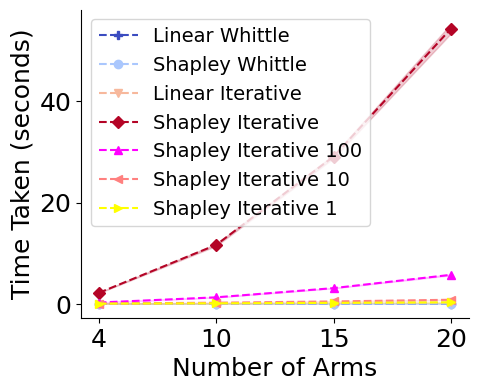

In [57]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','shapley_iterative_whittle_100','shapley_iterative_whittle_10','shapley_iterative_whittle_1']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Shapley Iterative 100","Shapley Iterative 10","Shapley Iterative 1"]
time_taken = [0.01,0.1,1]
width = 0.1
plt.figure(figsize=(5,4))
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform'})
        results = aggregate_data(results)
        score_by_n.append(results['{}_time'.format(m)][0])
        std_by_n.append(results['{}_time'.format(m)][1])
    plt.fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=colors_by_method[m])
    plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
plt.legend(loc="upper left")
plt.xticks(np.array(list(range(len(n_arms)))),n_arms)
plt.xlabel("Number of Arms")
plt.ylabel("Time Taken (seconds)")
plt.savefig("../../results/figures/time_taken.pdf",dpi=300, bbox_inches='tight')

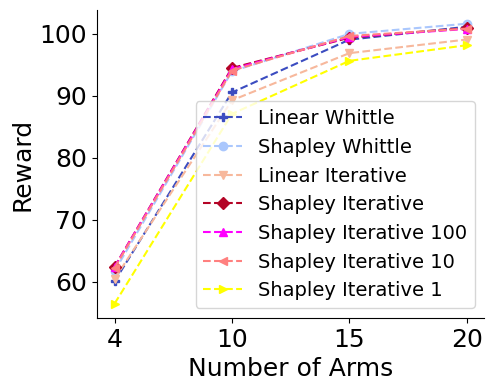

In [58]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','shapley_iterative_whittle_100','shapley_iterative_whittle_10','shapley_iterative_whittle_1']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Shapley Iterative 100","Shapley Iterative 10","Shapley Iterative 1"]
time_taken = [0.01,0.1,1]
width = 0.1
plt.figure(figsize=(5,4))
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform'})
        results = aggregate_data(results)
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    # plt.fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=colors_by_method[m])
    plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
plt.legend(loc="lower right")
plt.xticks(np.array(list(range(len(n_arms)))),n_arms)
plt.xlabel("Number of Arms")
plt.ylabel("Reward")
plt.savefig("../../results/figures/time_reward.pdf",dpi=300, bbox_inches='tight')

### Food Rescue

whittle_activity 0.11938240743781364
greedy 1.78525702105406
mcts 0.18190735584972687
dqn_step 0.8052721293520252
linear_whittle 2.1197341041101456
shapley_whittle_custom 2.1165414375074376
iterative_whittle 2.096556678853758
mcts_linear 0.3392764930894227
mcts_shapley 0.3374728814244722
whittle_activity -0.16077346872468515
greedy 1.020299822626686
mcts 0.4627812612635138
dqn_step 0.8646354809486143
linear_whittle 1.243472654413677
shapley_whittle_custom 1.2555202699725057
iterative_whittle 1.266392071405025
shapley_iterative_whittle 1.277780859303859
mcts_linear 0.6283812135206873
mcts_shapley 0.5370997453594776


<Figure size 700x400 with 0 Axes>

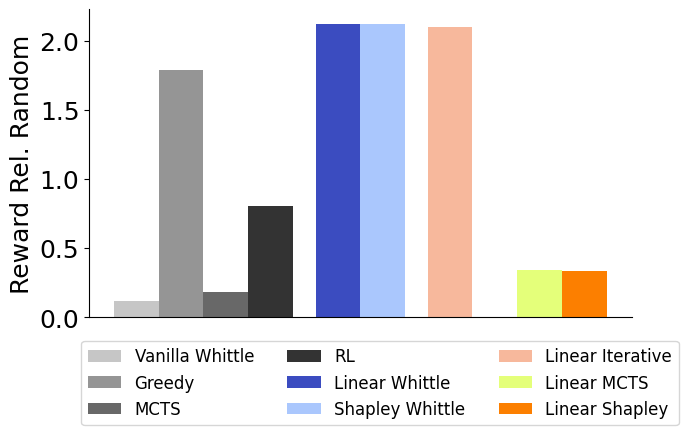

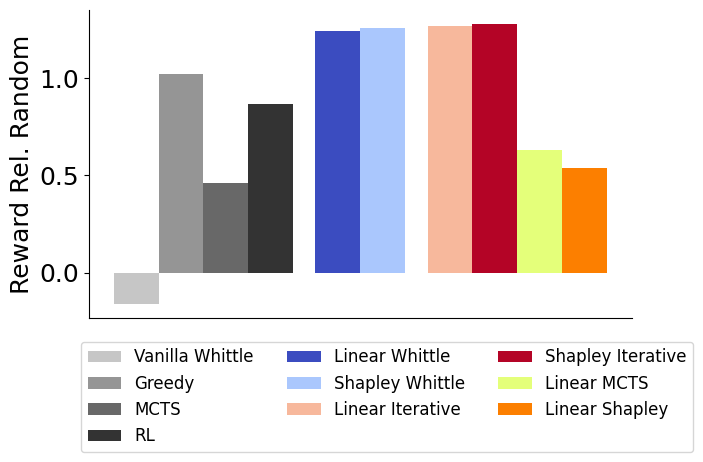

In [42]:
method_names = ['whittle_activity','greedy','mcts','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","MCTS","RL","Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative","Linear MCTS","Linear Shapley"]
n_arms = [4]
width = 0.1
plt.figure(figsize=(7,4))

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for k in range(len(distros)):
    plt.figure(figsize=(7,4))
    volunteers = arm_budget[k][0] 
    volunteers_per_arm = arm_budget[k][1]
    budget = arm_budget[k][2]
    for i,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        if m == 'shapley_iterative_whittle' and volunteers*volunteers_per_arm > 25:
            continue 

        for n in n_arms:
            params = {'volunteers_per_arm': volunteers_per_arm, 'lamb': 0.5, 'budget': budget, 'n_arms': volunteers, 'time_limit': 100,'n_episodes': 100, 'prob_distro': distros[k]}
            
            results = get_results_matching_parameters(dataset,"",params)
            results = aggregate_normalize_data(results,baseline="random")
            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1])
        print(m,np.mean(score_by_n))
        
        if m == 'optimal':
            plt.hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            plt.bar(x_locations[i],score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])

    plt.legend(loc='upper left',fontsize=12,ncol=3,bbox_to_anchor=(-0.03,-0.05))
    plt.xticks([])
    plt.ylabel("Reward Rel. Random")
    plt.savefig("../../results/figures/food_rescue_{}.pdf".format(volunteers*volunteers_per_arm),dpi=300, bbox_inches='tight')


### Ablations

#### Food Rescue Exploration

/tmp/ipykernel_915167/1690717028.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


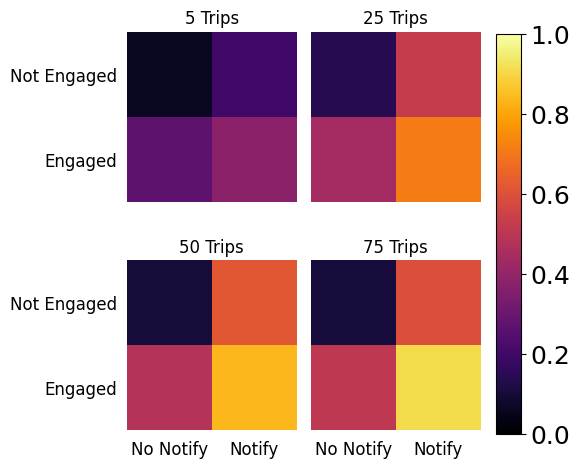

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
all_population_size = 100 
all_transitions = get_all_transitions(all_population_size)
vmax=  1
vmin = 0

transition_sizes = [[3,23],[48,73]]

for i in range(2):
    for j in range(2):
        a = axs[i,j].imshow(all_transitions[transition_sizes[i][j],:,:,1],cmap='inferno',vmax=vmax,vmin=vmin)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title("{} Trips".format(transition_sizes[i][j]+2))

        if i == 1:
            axs[i,j].set_xticks([0,1],['No Notify','Notify'],fontsize=12)
        
        if j == 0:
            axs[i,j].set_yticks([0,1],['Not Engaged','Engaged'],fontsize=12)
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].spines['bottom'].set_visible(False)
        axs[i,j].tick_params(left=False,bottom=False)

# fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
fig.colorbar(a, cax=cbar_ax)

# Adjust layout
plt.tight_layout()
plt.savefig("../../results/figures/transition_distro_food_rescue.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_915167/1171396222.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratios, color="blue", shade=True)


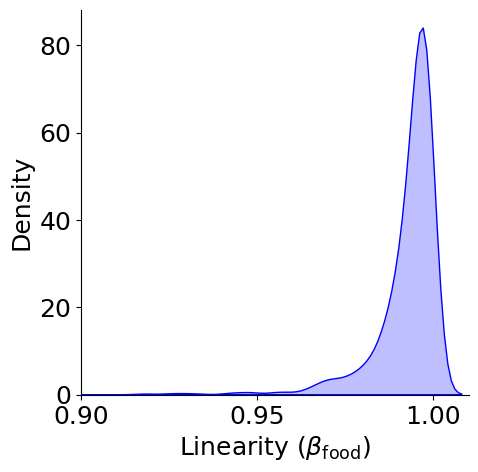

In [105]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

samples = 1000
ratios = []

combination_probs = [math.comb(len(probs_by_user),i) for i in range(1,6)]
combination_probs = np.array(combination_probs)
combination_probs = combination_probs/np.sum(combination_probs)

for i in range(samples):
    choices = np.random.choice(list(range(len(all_non_zero_probs))),random.choices(list(range(1,6)), combination_probs)[0])
    sum_probabilities = np.sum(all_non_zero_probs[choices])
    actual_prob = 1
    for prob in all_non_zero_probs[choices]:
        actual_prob *= (1-prob)
    actual_prob = 1-actual_prob
    ratios.append(actual_prob/sum_probabilities)
sns.kdeplot(ratios, color="blue", shade=True)
plt.xticks([0.9,0.95,1.0])
plt.xlim([0.9,1.01])
plt.xlabel("Linearity ($\\beta_{\\mathrm{food}}$)")
plt.savefig("../../results/figures/food_rescue_distro.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_915167/11957407.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)


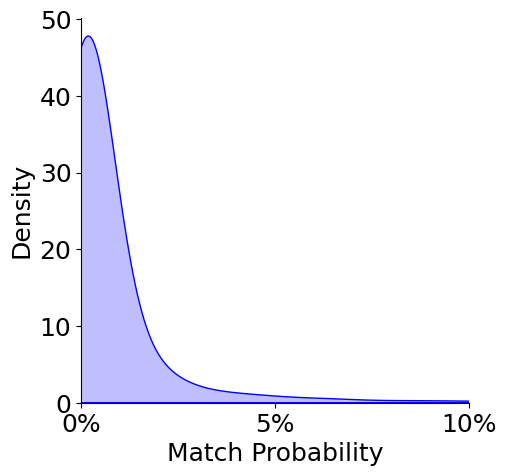

In [106]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)
plt.xlim([0.0,0.1])
plt.xticks([0,0.05,0.1],['0%','5%','10%'])
plt.xlabel("Match Probability")
plt.savefig("../../results/figures/food_rescue_match_distro.pdf",dpi=300, bbox_inches='tight')


#### Model Comparison

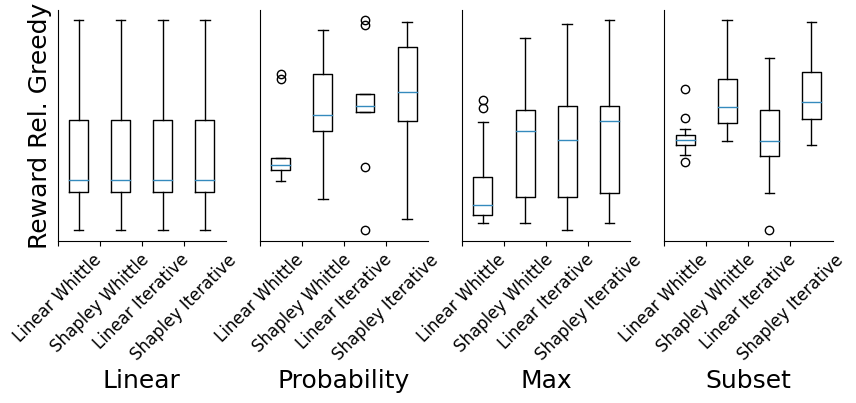

In [107]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]

probability_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_low': 0, 'arm_set_high': 1, 'time_limit': 100}
max_reward_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_high': 1,'time_limit': 100}
subset_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 10//2,'n_arms': 10, 'arm_set_low': 6,'arm_set_high': 8,'time_limit': 100}

probability_data = []
max_data = []
subset_data = []
linear_data = []

for reward_type, reward_list, reward_params in zip(["linear_reward","prob_reward","max_reward","subset_reward"],[linear_data,probability_data,max_data,subset_data],[probability_params,probability_params,max_reward_params,subset_params]):
    for i,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "reward_variation/{}".format(reward_type)

        results = get_results_matching_parameters(dataset,"",reward_params)
        reward_list.append([i['{}_reward'.format(m)][0] - i['greedy_reward'][0] for i in results])

axs[0].boxplot(linear_data)
axs[1].boxplot(probability_data)
axs[2].boxplot(max_data)
axs[3].boxplot(subset_data)

for i in range(len(axs)):
    # axs[i].set_ylim([-6,9])
    if i == 0:
        axs[i].set_yticks([])
    else:
        axs[i].set_yticks([])
    axs[i].set_xticks([0.5,1.5,2.5,3.5],nice_names,rotation=45,fontsize=12)
    # else:
    #     axs[i].set_xticks([])

axs[0].set_xlabel("Linear")
axs[1].set_xlabel("Probability")
axs[2].set_xlabel("Max")
axs[3].set_xlabel("Subset")
axs[0].set_ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/reward_distro.pdf",dpi=300, bbox_inches='tight')

#### Budget/N Arms Ablation

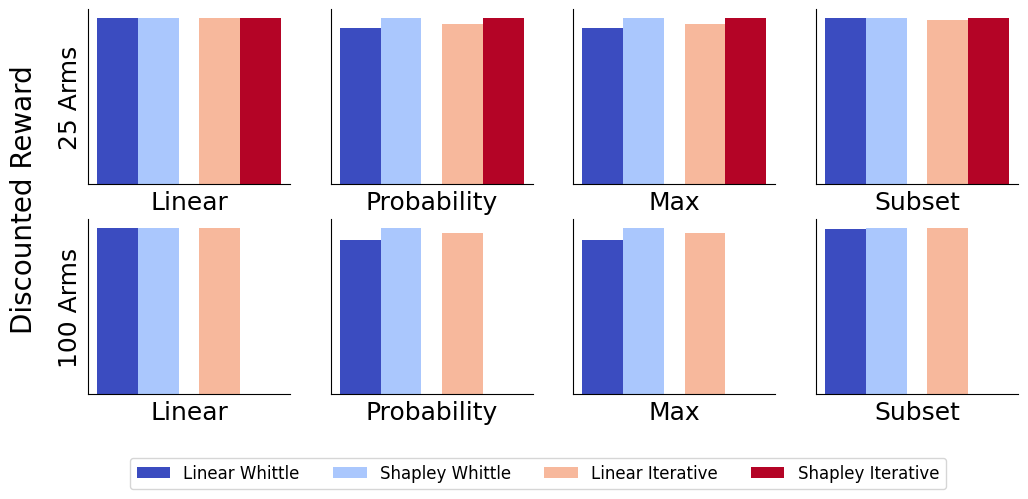

<Figure size 700x400 with 0 Axes>

In [108]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [25,100]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform'}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)
            results = aggregate_data(results)
            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1])
        
            if m == 'optimal':
                axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_xlabel(reward_names[j])

axs[0,0].set_ylabel("25 Arms")
axs[1,0].set_ylabel("100 Arms")

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=12)

fig.supylabel("Discounted Reward",fontsize=20,x=0.06)

fig.savefig("../../results/figures/all_rewards_large_N.pdf",dpi=300, bbox_inches='tight')


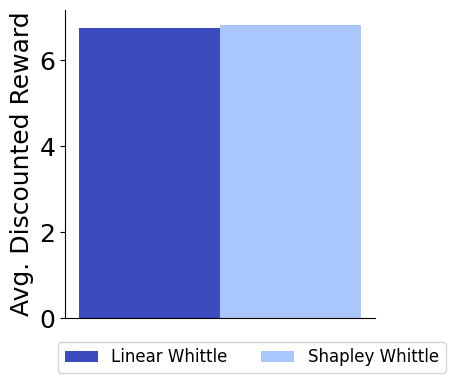

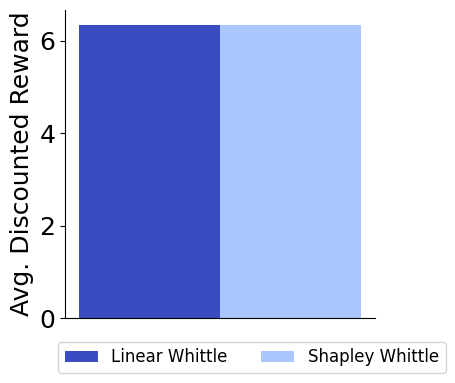

In [109]:
method_names = ['linear_whittle','shapley_whittle_custom']
nice_names = ["Linear Whittle","Shapley Whittle"]
n_arms = [4]
width = 0.1

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,10,250),(5,50,5)]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for k in range(len(distros)):
    plt.figure(figsize=(4,4))
    volunteers = arm_budget[k][0] 
    volunteers_per_arm = arm_budget[k][1]
    budget = arm_budget[k][2]
    for i,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "food_rescue_policies"

        for n in n_arms:
            params = {'volunteers_per_arm': volunteers_per_arm, 'lamb': 0.5, 'budget': budget, 'n_arms': volunteers, 'time_limit': 100,'prob_distro': distros[k]}
            
            results = get_results_matching_parameters(dataset,"",params)
            results = aggregate_data(results)
            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1])
        
        if m == 'optimal':
            plt.hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            plt.bar(x_locations[i],score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])

    plt.legend(loc='upper left',fontsize=12,ncol=3,bbox_to_anchor=(-0.05,-0.05))
    plt.xticks([])
    plt.ylabel("Avg. Discounted Reward")
    plt.savefig("../../results/figures/food_rescue_{}.pdf".format(volunteers*volunteers_per_arm),dpi=300, bbox_inches='tight')


#### MCTS RL Ablations

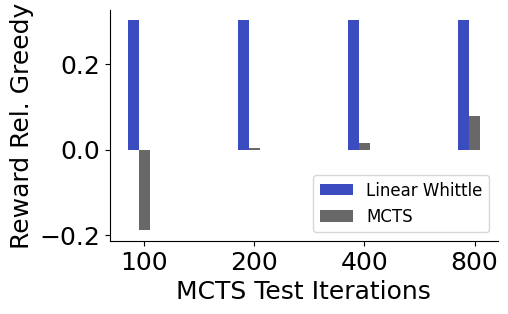

In [110]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear Whittle","MCTS"]
mcts_iterations = [100,200,400,800]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for test_iterations in mcts_iterations:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': 2, 'test_iterations': test_iterations})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(mcts_iterations))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
plt.legend(loc="lower right",fontsize=12)
plt.xticks(np.array(list(range(len(mcts_iterations))))+width*len(method_names)/2,mcts_iterations)
plt.xlabel("MCTS Test Iterations")
plt.ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/mcts_iterations.pdf",dpi=300, bbox_inches='tight')

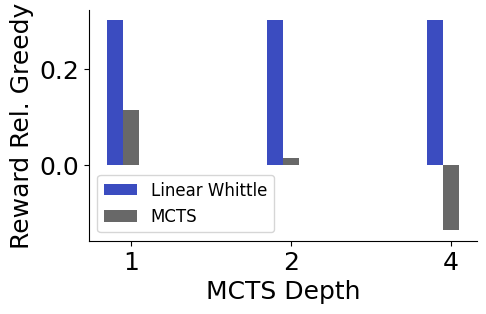

In [111]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear Whittle","MCTS"]
mcts_depth = [1,2,4]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for depth in mcts_depth:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': depth, 'test_iterations': 400})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(mcts_depth))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
plt.legend(loc="lower left",fontsize=12)
plt.xticks(np.array(list(range(len(mcts_depth))))+width*len(method_names)/2,mcts_depth)
plt.xlabel("MCTS Depth")
plt.ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/mcts_depth.pdf",dpi=300, bbox_inches='tight')

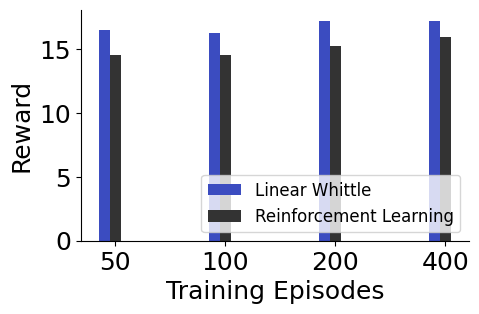

In [112]:
method_names = ["linear_whittle",'dqn_step']
nice_names = ["Linear Whittle","Reinforcement Learning"]
n_episodes = [50,100,200,400]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/rl"

    for n_episode in n_episodes:
        results_raw = get_results_matching_parameters(dataset,"",{'n_arms': 10,  'volunteers_per_arm': 1,  'n_episodes': n_episode, 'time_limit': 100, 'reward_type': 'linear'})
        params = results_raw[0]['parameters']
        results = aggregate_data(results_raw)
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    if m in colors_by_method:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
    else:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=12)
plt.xticks(np.array(list(range(len(n_episodes))))+width*len(method_names)/2,n_episodes)
plt.xlabel("Training Episodes")
plt.ylabel("Reward")
plt.savefig("../../results/figures/dqn_ablation.pdf",dpi=300, bbox_inches='tight')

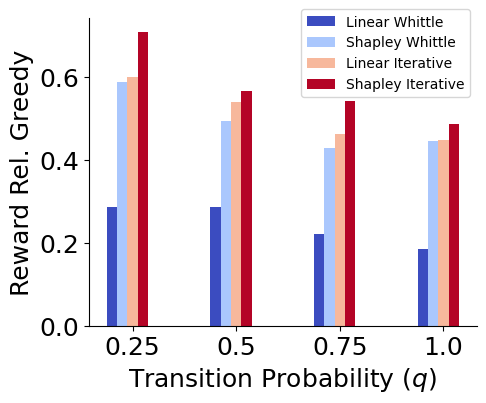

In [113]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]
min_prob = [0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(5,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/synthetic_transitions"

    for prob in min_prob:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'max_prob': prob})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(min_prob))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
plt.legend(loc="upper right",fontsize=10,bbox_to_anchor=(1,1.05))
plt.xticks(np.array(list(range(len(min_prob))))+width*len(method_names)/2,min_prob)
plt.xlabel("Transition Probability ($q$)")
plt.ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/synthetic_transition.pdf",dpi=300, bbox_inches='tight')

#### Alpha

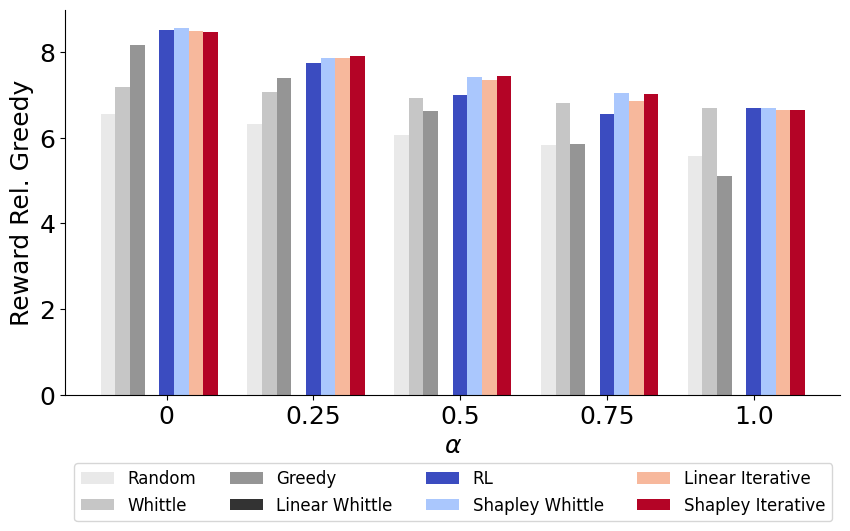

In [125]:
method_names = ['random','whittle_activity','greedy','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Random","Whittle","Greedy","Linear Whittle","RL","Shapley Whittle","Linear Iterative","Shapley Iterative",]
lamb_values = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,5))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for lamb in lamb_values:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': lamb, 'budget': 5, 'n_arms': 10, 'arm_set_low': 0, 'arm_set_high': 1, 'prob_distro': 'uniform', 'n_episodes': 100})
        results = aggregate_data(results)
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(lamb_values))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
plt.legend(loc="lower right",fontsize=12,ncol=4,bbox_to_anchor=(1.0,-0.35))
plt.xticks(np.array(list(range(len(lamb_values))))+width*len(method_names)/2,lamb_values)
plt.xlabel("$\\alpha$")
plt.ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/alpha.pdf",dpi=300, bbox_inches='tight')

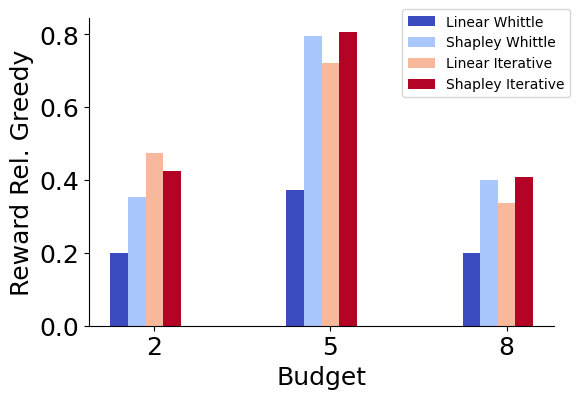

In [115]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle']
nice_names = ["Linear Whittle","Shapley Whittle","Linear Iterative","Shapley Iterative"]
budgets = [10//4,10//2,round(10*0.75)]
width = 0.1
plt.figure(figsize=(6,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': b, 'n_arms': 10, 'n_episodes': 100})
        results = aggregate_normalize_data(results,baseline="greedy")
        if '{}_reward'.format(m) not in results:
            results['{}_reward'.format(m)] = [0,0]
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1])
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m])
plt.legend(loc="upper right",fontsize=10,bbox_to_anchor=(1.05,1.05))
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets)
plt.xlabel("Budget")
plt.ylabel("Reward Rel. Greedy")
plt.savefig("../../results/figures/budget.pdf",dpi=300, bbox_inches='tight')